# 0 Import Statements

In [1]:
#!pip install opencv-python
#!pip install scikit-learn
#!pip install imblearn
#!pip install tensorflow
#!pip install seaborn

import cv2
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input, AveragePooling2D, concatenate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(1000)

# 1 Preprocessing

## 1.1 Read-in data

In [2]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [3]:
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

## 1.2 Shuffle the dataframe and split it into X (image paths) and y (labels)

In [4]:
# shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)
print(df_shuffled.head(5))
# split data into features (X) and labels (y)
X = df_shuffled["image"]
y = df_shuffled["label"]

                          image  label
0  ESP_027475_2310_RED-0112.jpg      0
1  ESP_034557_1510_RED-0201.jpg      0
2  PSP_002455_1320_RED-0111.jpg      2
3  PSP_010587_1620_RED-0342.jpg      0
4  ESP_033955_2065_RED-0059.jpg      0


## 1.3 Train-Test-Split

In [5]:
# splitting the data into train, test and validation sets
Xp_train_before, Xp_temp, yp_train_before, yp_temp = train_test_split(X, y, test_size=0.4, random_state=42)
Xp_test, Xp_val, yp_test, yp_val = train_test_split(Xp_temp, yp_temp, test_size=0.3, random_state=42)
print(Xp_train_before.shape, yp_train_before.shape, "Train")
print(Xp_test.shape, yp_test.shape, "Test")
print(Xp_val.shape, yp_val.shape, "Validation")

(6489,) (6489,) Train
(3028,) (3028,) Test
(1298,) (1298,) Validation


In [6]:
print(np.unique(yp_train_before, return_counts=True))
print(np.around(np.unique(yp_train_before, return_counts=True)[1]/yp_train_before.shape[0], decimals=4))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5240,  479,  102,  181,  152,   47,  181,  107]))
[0.8075 0.0738 0.0157 0.0279 0.0234 0.0072 0.0279 0.0165]


## 1.4 Filter 4.5k images from the train set

In [7]:
# filter 4.5k images from the train set and corresponding labels
index = Xp_train_before[yp_train_before == 0].sample(n=4500, random_state=42).index
Xp_train = Xp_train_before.drop(index)
yp_train = yp_train_before.drop(index)

print(Xp_train.shape, yp_train.shape)
print("Distribution of labels in the train set")
print(np.unique(yp_train, return_counts=True))
print(np.around(np.unique(yp_train, return_counts=True)[1]/yp_train.shape[0], decimals=4))

(1989,) (1989,)
Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]


## 1.5 Read-in images and normalize

In [8]:
# helper function that normalizes an input image
def normalize_image(image):
    image = image/255.0
    return image

# load the images from the path in the array and store them as pixels in an array
def load_images(X, y, folder):
    images = []
    labels = []
    for index in X.index:
        image = cv2.imread(folder+"/"+X[index], cv2.IMREAD_GRAYSCALE)
        image = normalize_image(image)
        if images is not None:
            images.append(image)
            labels.append(y[index])
    return np.array(images), np.array(labels)

In [9]:
# load the images from the train, test, and validation set
X_train, y_train = load_images(Xp_train, yp_train, "map-proj-v3_2")
X_test, y_test = load_images(Xp_test, yp_test, "map-proj-v3_2")
X_val, y_val = load_images(Xp_val, yp_val, "map-proj-v3_2")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1989, 227, 227) (1989,)
(3028, 227, 227) (3028,)
(1298, 227, 227) (1298,)


In [10]:
print("Distribution of labels in the train set before filtering 5.4k images")
print(np.unique(yp_train_before, return_counts=True))
print(np.around(np.unique(yp_train_before, return_counts=True)[1]/yp_train_before.shape[0], decimals=4))
print("\nDistribution of labels in the train set")
print(np.unique(y_train, return_counts=True))
print(np.around(np.unique(y_train, return_counts=True)[1]/y_train.shape[0], decimals=4))
print("\nDistribution of labels in the test set")
print(np.unique(y_test, return_counts=True))
print(np.around(np.unique(y_test, return_counts=True)[1]/y_test.shape[0], decimals=4))
print("\nDistribution of labels in the validation set")
print(np.unique(y_val, return_counts=True))
print(np.around(np.unique(y_val, return_counts=True)[1]/y_val.shape[0], decimals=4))

Distribution of labels in the train set before filtering 5.4k images
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([5240,  479,  102,  181,  152,   47,  181,  107]))
[0.8075 0.0738 0.0157 0.0279 0.0234 0.0072 0.0279 0.0165]

Distribution of labels in the train set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([740, 479, 102, 181, 152,  47, 181, 107]))
[0.372  0.2408 0.0513 0.091  0.0764 0.0236 0.091  0.0538]

Distribution of labels in the test set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2505,  214,   44,   59,   69,   19,   75,   43]))
[0.8273 0.0707 0.0145 0.0195 0.0228 0.0063 0.0248 0.0142]

Distribution of labels in the validation set
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1057,  101,   20,   27,   29,    8,   42,   14]))
[0.8143 0.0778 0.0154 0.0208 0.0223 0.0062 0.0324 0.0108]


## 1.6 Imbalance handling

### 1.6.0 Flatten images

In [11]:
# faltten the images to feed them to the ADASYN and random oversampling algorithm
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(1989, 227, 227)
(1989, 51529)


### 1.6.1 ADASYN

In [12]:
# apply ADASYN oversampling algorithm to the train set
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train) # type: ignore

### 1.6.2 Oversampling

In [13]:
# apply random oversampling algorithm to the train set
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=3)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_train) # type: ignore

In [16]:
# double check that the oversampling worked - first label and all labels
l1 = pd.DataFrame(X_resampled[np.where(y_resampled == 1)[0]])
print(f"Number of duplicates for the first label after oversampling: {l1.duplicated().sum()}")
all_l = pd.DataFrame(X_resampled)
print(f"Number of duplicates for all labels after oversampling: {all_l.duplicated().sum()}")

Number of duplicates for the first label after oversampling: 261
Number of duplicates for all labels after oversampling: 3931


### 1.6.3 Overview of datasets

In [17]:
# comparing the three datasets used for training: original, ADASYN, and random oversampling
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
unique_b, counts_b = np.unique(y_resampled, return_counts=True)
print(unique, counts)
print(unique_a, counts_a)
print(unique_b, counts_b)

[0 1 2 3 4 5 6 7] [740 479 102 181 152  47 181 107]
[0 1 2 3 4 5 6 7] [740 701 730 729 748 736 767 740]
[0 1 2 3 4 5 6 7] [740 740 740 740 740 740 740 740]


In [18]:
# reshahping the images back to original form of 227x227
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227) # type: ignore
y_t_A = y_train_adasyn

X_t_O = X_resampled.reshape(X_resampled.shape[0], 227, 227) # type: ignore
y_t_O = y_resampled

print(f"Shape of training original training instances: \n{X_train.shape}, correspoding y: {y_train.shape}")
print(f"Shape of training instances generated by ADASYN: \n{X_t_A.shape}, correspoding y: {y_t_A.shape}")
print(f"Shape of training instances generated by RandomOverSampler: \n{X_t_O.shape}, correspoding y: {y_t_O.shape}")

Shape of training original training instances: 
(1989, 227, 227), correspoding y: (1989,)
Shape of training instances generated by ADASYN: 
(5891, 227, 227), correspoding y: (5891,)
Shape of training instances generated by RandomOverSampler: 
(5920, 227, 227), correspoding y: (5920,)


## 1.7 Augmentation
Rotate 90, 180, 270, Flip Horizontally, Flip Vertically, Zoom (1.2)

In [19]:
# helper function used to create zoomed images
def zoom_at(img, zoom):
    h, w, = [zoom * i for i in img.shape]
    cx, cy = w/2, h/2
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

# augmenting the images in 6 different ways and adding them to the training set
def augment_images(images, labels):

    # Empty numpy array to store the augmented images and return once all images have been augmented
    augmented_images = np.empty((7*images.shape[0], images.shape[1], images.shape[2]))
    augmented_labels = np.empty((7*images.shape[0]))
    

    # Loop through each image in the array and perform the augmentations
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]

        # Add the original image to the output array
        augmented_images[(i*7)] = image
        augmented_labels[(i*7)] = label
        
        # Rotate the image by 90 degrees
        rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        augmented_images[(i*7)+1] = rotated_90
        augmented_labels[(i*7)+1] = label
        
        # Rotate the image by 180 degrees
        rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
        augmented_images[(i*7)+2] = rotated_180
        augmented_labels[(i*7)+2] = label
        
        # Rotate the image by 270 degrees
        rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images[(i*7)+3] = rotated_270
        augmented_labels[(i*7)+3] = label
        
        # Flip the image horizontally
        flipped_horizontal = cv2.flip(image, 1)
        augmented_images[(i*7)+4] = flipped_horizontal
        augmented_labels[(i*7)+4] = label
        
        # Flip the image vertically
        flipped_vertical = cv2.flip(image, 0)
        augmented_images[(i*7)+5] = flipped_vertical
        augmented_labels[(i*7)+5] = label
        
        # Zoom in on the image
        zoomed_in = zoom_at(image, 1.2)
        augmented_images[(i*7)+6] = zoomed_in
        augmented_labels[(i*7)+6] = label

        #print(f"Image, {i} done")

    return augmented_images, augmented_labels

### 1.7.1 Augment the three trainings sets

In [ ]:
X_t_A_A, y_t_A_A = augment_images(X_t_A, y_t_A) # ADASYN
X_t_O_A, y_t_O_A = augment_images(X_t_O, y_t_O) # Random Oversampling
print(f"Shape of original training data for ADASYN: {X_t_A.shape} with corresponding y: {y_t_A.shape}")
print(f"Shape of augmented training data for ADASYN: {X_t_A_A.shape} with corresponding y: {y_t_A_A.shape}")
print(f"Shape of original training data for RandomOverSampler: {X_t_O.shape} with corresponding y: {y_t_O.shape}")
print(f"Shape of augmented training data for RandomOverSampler: {X_t_O_A.shape} with corresponding y: {y_t_O_A.shape}")

Shape of original training data for ADASYN: (5891, 227, 227) with corresponding y: (5891,)
Shape of augmented training data for ADASYN: (41237, 227, 227) with corresponding y: (41237,)
Shape of original training data for RandomOverSampler: (5920, 227, 227) with corresponding y: (5920,)
Shape of augmented training data for RandomOverSampler: (41440, 227, 227) with corresponding y: (41440,)


In [ ]:
X_train_A, y_train_A = augment_images(X_train, y_train) # Original
print(f"Shape of original training data: {X_train.shape} with corresponding y: {y_train.shape}")
print(f"Shape of augmented training data: {X_train_A.shape} with corresponding y: {y_train_A.shape}")

Shape of original training data: (1989, 227, 227) with corresponding y: (1989,)
Shape of augmented training data: (13923, 227, 227) with corresponding y: (13923,)


## 1.8 Displaying random images and their augmentations

In [20]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom"]
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

# choosing random images from the training data that are originals (divisible by 7)
def generate_random_integers(X, n):
    random_integers = []
    while len(random_integers) < n:
        integer = np.random.randint(0, len(X))
        if integer % 7 == 0:
            random_integers.append(integer)
    return random_integers

# plotting the original images and their augmentations (following 6 images)
def plot_augmented_images(X, y, aug_names, class_names, num_images):
    indices = generate_random_integers(X, num_images)
    fig, axes = plt.subplots(len(indices), 7, figsize=(15, 15))
    c = 0
    for i in indices:
        for j in range(7):
            axes[c, j].imshow(X[i+j], cmap="gray")
            axes[c, j].set_xticks([])
            axes[c, j].set_yticks([])
            
            axes[c, j].set_xlabel(aug_names[j] + " " + str(int(i+j)))
            if j == 0:
                axes[c, j].set_ylabel(class_names[int(y[i+j])])
        c += 1
    plt.show()

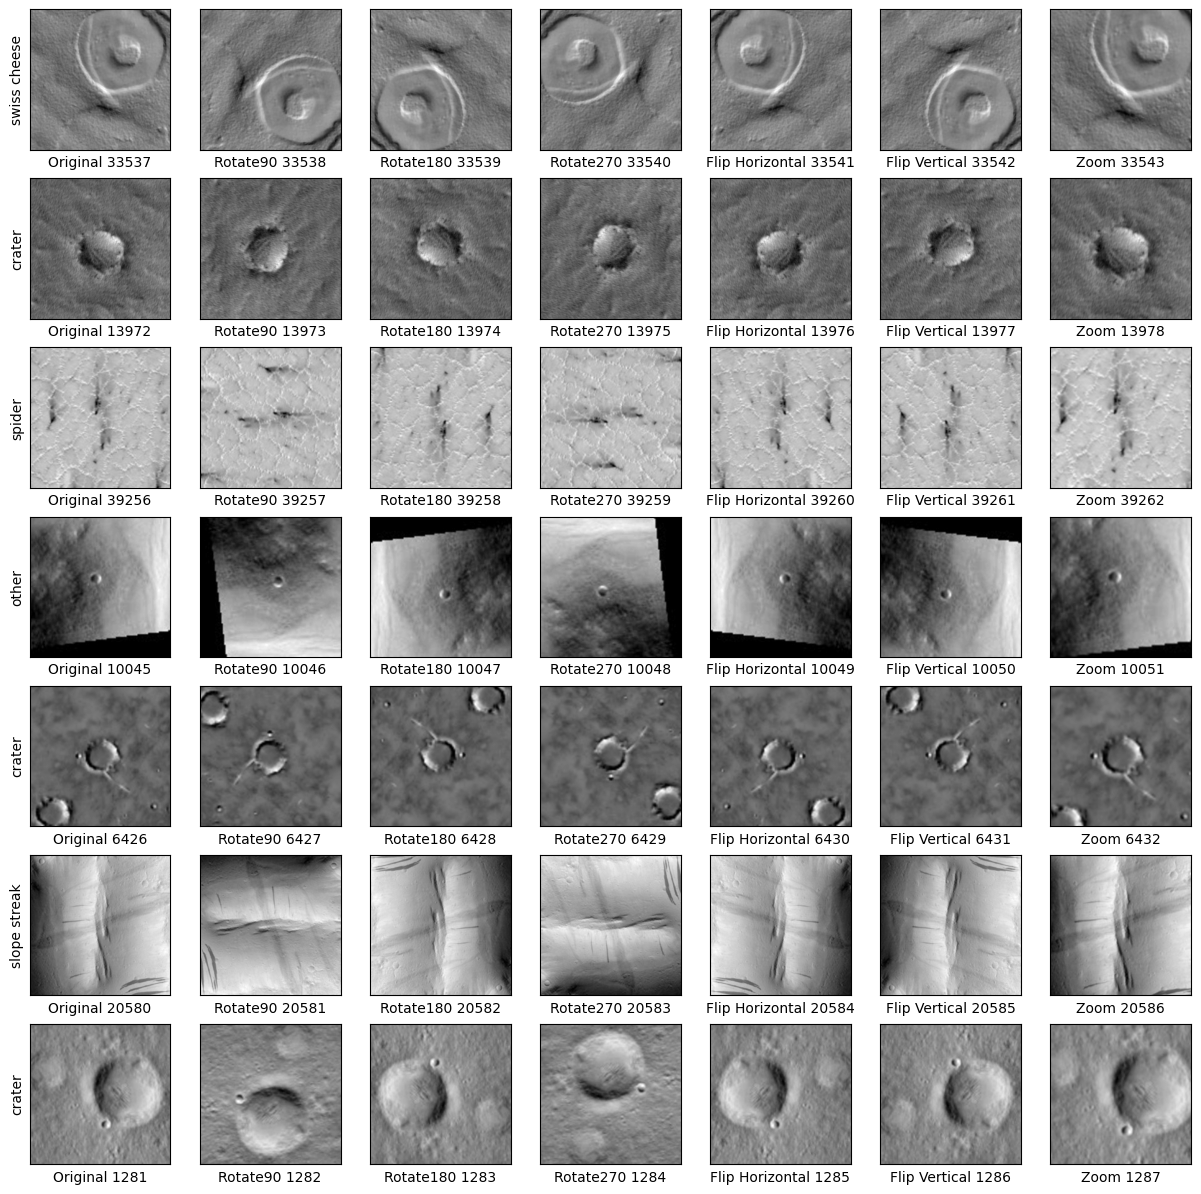

In [21]:
plot_augmented_images(X_t_A_A, y_t_A_A, aug_names, class_names, 7)

# 2 Train models and report their performance

## 2.0 Helper Functions

In [22]:
# shuffle data before used as trainings data as it is ordered after augmentation
def shuffle_data(x, y):
    assert x.shape[0] == y.shape[0]
    p = np.random.permutation(x.shape[0])
    return x[p], y[p]

In [23]:
# function used to show the accuracy, classification report and confusion matrix of a given model
# automatically called after training the neural network
def model_evaluation(model, history, X_test, y_test, class_names):
    sns.lineplot(data=history.history['accuracy'], label='accuracy')
    sns.lineplot(data=history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
    print("Accuracy on the training set:", test_acc)
    y_pred_prob = model.predict(X_test)
    y_pred_class = y_pred_prob.argmax(axis=-1)

    print(classification_report(y_pred_class, y_test, target_names=class_names))
    fig = plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_pred_class, y_test), xticklabels=class_names, yticklabels=class_names, annot=True)
    plt.show()

## 2.1 AlexNet with the three datasets

In [24]:
# creating the alex net and training it (loss function, optimizer and some hyperparameters are predefined)
def run_alex(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate, weight_decay, momentum, batch_size, epochs, class_names):
    alex = Sequential()
    
    alex.add(Conv2D(filters=96, input_shape=(227, 227, 1), kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    alex.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    alex.add(Flatten())
    alex.add(Dense(4096, input_shape=(227*227*1,), activation='relu'))
    alex.add(Dropout(0.5))
    alex.add(Dense(4096, activation='relu'))
    alex.add(Dropout(0.5))
    alex.add(Dense(8))
    alex.add(Activation('softmax'))
    
    alex.summary()
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)
    loss_function = keras.losses.SparseCategoricalCrossentropy()
    
    alex.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    
    history = alex.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

    model_evaluation(alex, history, X_test, y_test, class_names)

    return alex, history

### 2.1.1 Trainingsset: RandomOversampling (batch_size=128, learning_rate=0.01)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

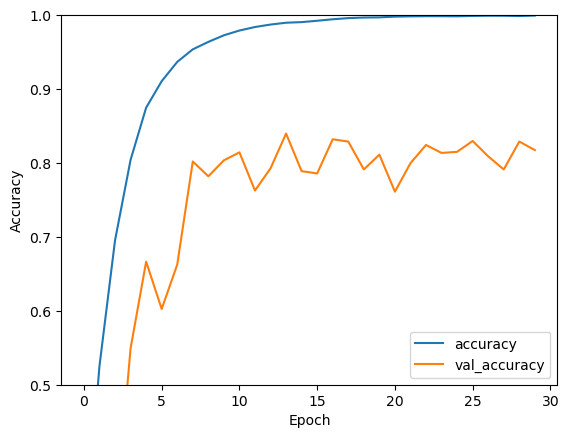

95/95 - 5s - loss: 1.2838 - accuracy: 0.8042 - 5s/epoch - 50ms/step
Accuracy on the training set: 0.8041611909866333
95/95 [==============================] - 5s 49ms/step
               precision    recall  f1-score   support

        other       0.80      0.97      0.88      2070
       crater       0.86      0.57      0.69       320
    dark dune       0.73      0.48      0.58        67
 slope streak       0.71      0.17      0.28       246
  bright dune       0.96      0.74      0.84        89
impact ejecta       0.42      0.25      0.31        32
 swiss cheese       0.83      0.47      0.60       132
       spider       0.84      0.50      0.63        72

     accuracy                           0.80      3028
    macro avg       0.77      0.52      0.60      3028
 weighted avg       0.80      0.80      0.78      3028



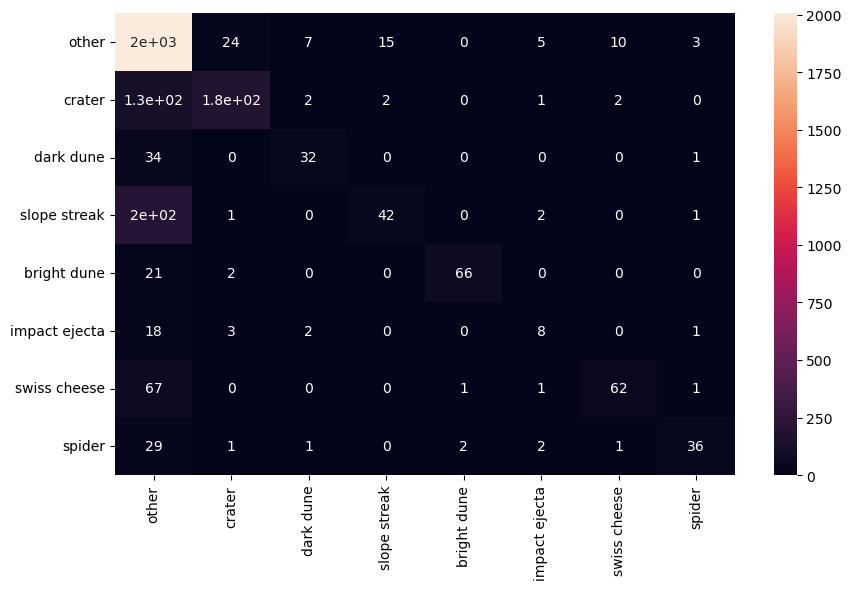

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_O_A_S, y_t_O_A_S, = shuffle_data(X_t_O_A, y_t_O_A) # Random Oversampling data

# Hyperparameters
learning_rate = 0.01
weight_decay = 0.0005
momentum = 0.9
batch_size = 128
epochs = 30

alex_O, history_alex_O = run_alex(X_train=X_t_O_A_S, y_train=y_t_O_A_S, 
                                 X_val=X_val, y_val=y_val,
                                 X_test=X_test, y_test=y_test,
                                 learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum,
                                 batch_size=batch_size, epochs=epochs,
                                 class_names=class_names)

### 2.1.2 Trainingsset: ADASYN (batch_size=32, learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

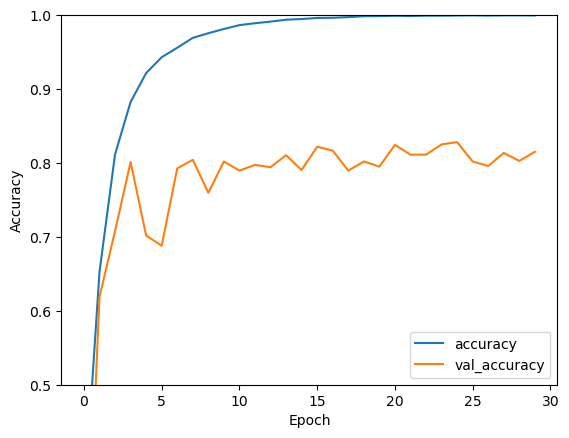

95/95 - 4s - loss: 1.1291 - accuracy: 0.8187 - 4s/epoch - 46ms/step
Accuracy on the training set: 0.8186922073364258
95/95 [==============================] - 5s 47ms/step
               precision    recall  f1-score   support

        other       0.81      0.97      0.88      2084
       crater       0.89      0.56      0.69       341
    dark dune       0.73      0.50      0.59        64
 slope streak       0.78      0.23      0.35       203
  bright dune       0.93      0.72      0.81        89
impact ejecta       0.47      0.24      0.32        38
 swiss cheese       0.91      0.54      0.67       127
       spider       0.91      0.48      0.62        82

     accuracy                           0.82      3028
    macro avg       0.80      0.53      0.62      3028
 weighted avg       0.82      0.82      0.80      3028



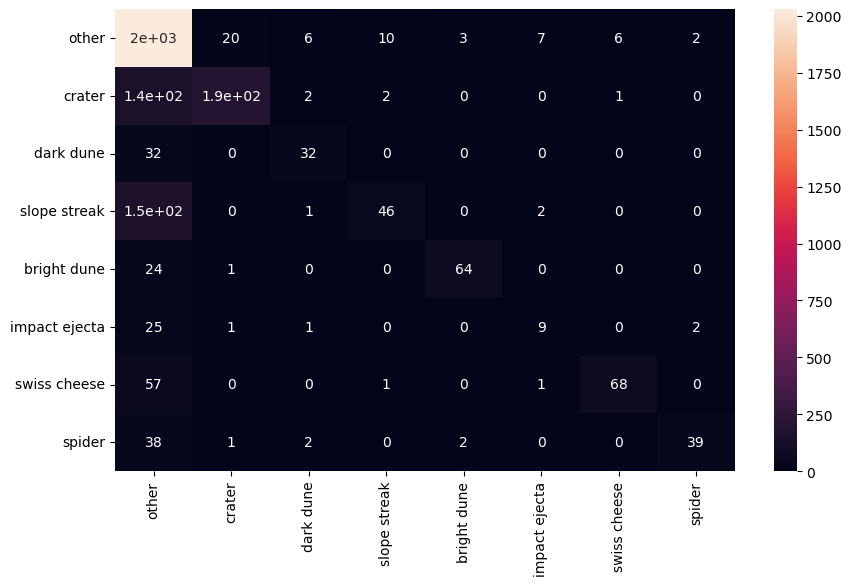

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_A_A_S, y_t_A_A_S, = shuffle_data(X_t_A_A, y_t_A_A) # ADASYN data

# Hyperparameters
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9
batch_size = 32
epochs = 30

alex_A, history_alex_A = run_alex(X_train=X_t_A_A_S, y_train=y_t_A_A_S, 
                                 X_val=X_val, y_val=y_val,
                                 X_test=X_test, y_test=y_test,
                                 learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum,
                                 batch_size=batch_size, epochs=epochs,
                                 class_names=class_names)

### 2.1.3 Trainingsset: Original (batch_size=32, learning_rate=0.005)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

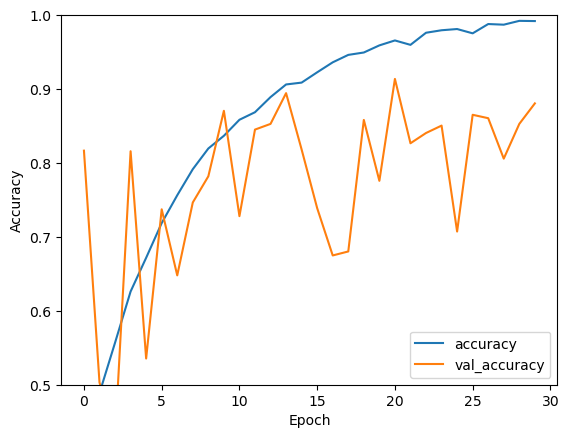

95/95 - 4s - loss: 0.7003 - accuracy: 0.8828 - 4s/epoch - 47ms/step
Accuracy on the training set: 0.8827608823776245
95/95 [==============================] - 5s 48ms/step
               precision    recall  f1-score   support

        other       0.91      0.96      0.93      2375
       crater       0.75      0.78      0.76       205
    dark dune       0.77      0.59      0.67        58
 slope streak       0.59      0.24      0.34       145
  bright dune       0.88      0.90      0.89        68
impact ejecta       0.26      0.56      0.36         9
 swiss cheese       0.85      0.63      0.72       102
       spider       0.91      0.59      0.72        66

     accuracy                           0.88      3028
    macro avg       0.74      0.65      0.67      3028
 weighted avg       0.88      0.88      0.87      3028



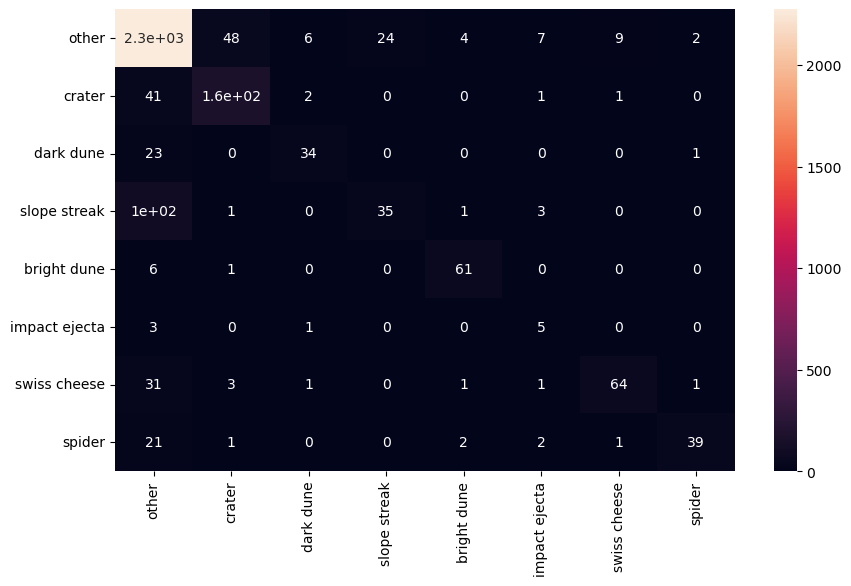

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_train_A_S, y_train_A_S, = shuffle_data(X_train_A, y_train_A) # Original data

# Hyperparameters
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9
batch_size = 32
epochs = 30

alex_A, history_alex_A = run_alex(X_train=X_train_A_S, y_train=y_train_A_S, 
                                 X_val=X_val, y_val=y_val,
                                 X_test=X_test, y_test=y_test,
                                 learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum,
                                 batch_size=batch_size, epochs=epochs,
                                 class_names=class_names)

## 3.1 GoogLeNet with the three datasets

In [ ]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=-1)

def GoogLeNet():
    input_layer = Input(shape=(227, 227, 1))

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1000, activation='sigmoid')(x)
    output_layer = Dense(8, activation='softmax')(x)

    # Define the model
    model_googlenet = keras.Model(input_layer, output_layer)

    # Return the model
    return model_googlenet

def run_google(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate, momentum, batch_size, epochs, class_names):
    google = GoogLeNet()
    
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    loss_function = keras.losses.SparseCategoricalCrossentropy()
    
    google.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])
    
    history = google.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    
    model_evaluation(google, history, X_test, y_test, class_names)
    
    return google, history

### 3.1.1 Trainingsset: RandomOversampling (batch_size=32, learning_rate=0.005)

Epoch 1/30
1295/1295 [==============================] - 1178s 908ms/step - loss: 1.8833 - accuracy: 0.2535 - val_loss: 2.0559 - val_accuracy: 0.1102
Epoch 2/30
1295/1295 [==============================] - 1199s 926ms/step - loss: 1.2696 - accuracy: 0.5335 - val_loss: 1.6527 - val_accuracy: 0.1949
Epoch 3/30
1295/1295 [==============================] - 1212s 936ms/step - loss: 0.7940 - accuracy: 0.7185 - val_loss: 0.9329 - val_accuracy: 0.6310
Epoch 4/30
1295/1295 [==============================] - 1213s 937ms/step - loss: 0.4795 - accuracy: 0.8277 - val_loss: 1.2113 - val_accuracy: 0.5470
Epoch 5/30
1295/1295 [==============================] - 1220s 942ms/step - loss: 0.3231 - accuracy: 0.8837 - val_loss: 0.7268 - val_accuracy: 0.7149
Epoch 6/30
1295/1295 [==============================] - 1221s 943ms/step - loss: 0.2419 - accuracy: 0.9129 - val_loss: 0.9708 - val_accuracy: 0.6733
Epoch 7/30
1295/1295 [==============================] - 1199s 926ms/step - loss: 0.1949 - accuracy: 0.9320

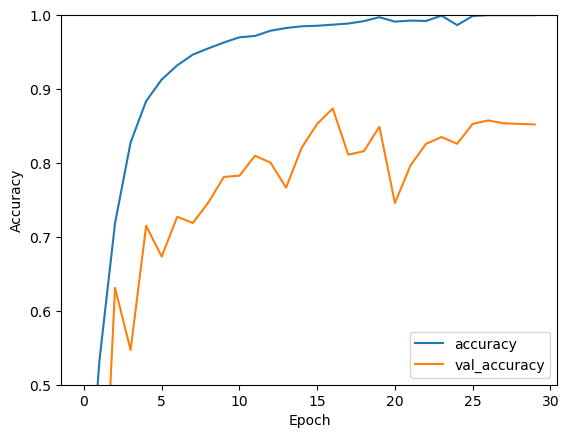

95/95 - 15s - loss: 0.8395 - accuracy: 0.8557 - 15s/epoch - 161ms/step
Accuracy on the training set: 0.8556803464889526
95/95 [==============================] - 16s 158ms/step
               precision    recall  f1-score   support

        other       0.85      0.98      0.91      2168
       crater       0.93      0.49      0.64       410
    dark dune       0.84      0.64      0.73        58
 slope streak       0.76      0.28      0.41       162
  bright dune       1.00      0.91      0.95        76
impact ejecta       0.26      0.31      0.29        16
 swiss cheese       0.96      0.86      0.91        84
       spider       0.88      0.70      0.78        54

     accuracy                           0.86      3028
    macro avg       0.81      0.65      0.70      3028
 weighted avg       0.86      0.86      0.84      3028



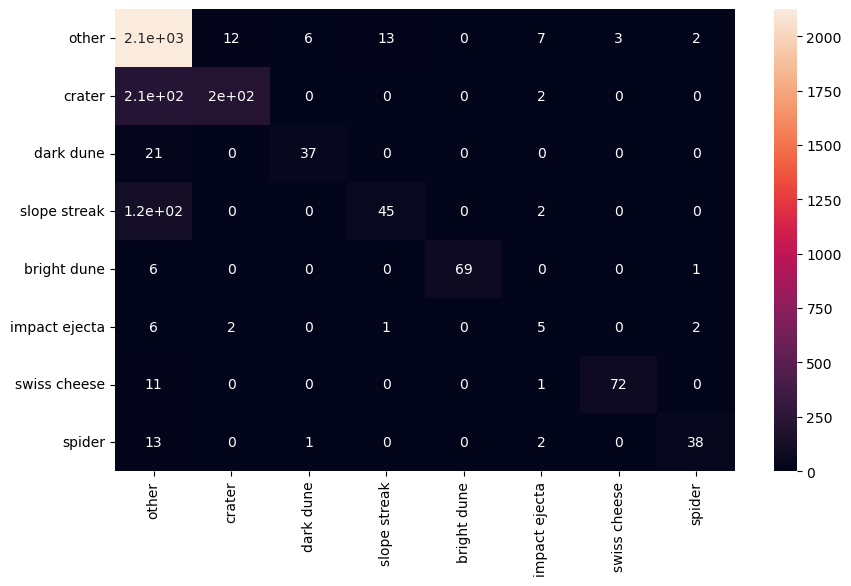

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_O_A_S, y_t_O_A_S, = shuffle_data(X_t_O_A, y_t_O_A) # Random Oversampling data

# Hyperparameters
learning_rate = 0.005
momentum = 0.9
batch_size = 32
epochs = 30

google_O, history_google_O = run_google(X_train=X_t_O_A_S, y_train=y_t_O_A_S, 
                                        X_val=X_val, y_val=y_val,
                                        X_test=X_test, y_test=y_test,
                                        learning_rate=learning_rate, momentum=momentum,
                                        batch_size=batch_size, epochs=epochs,
                                        class_names=class_names)

Display falsly classified images to analyze the model

In [ ]:
y_pred_prob = google_O.predict(X_test)
y_pred_class = y_pred_prob.argmax(axis=-1)
def falsely_correctly_classified(pred, test):
    false = []
    correct = []
    for i in range(len(pred)):
        if pred[i] == 1 and test[i] == 0:
            false.append(i)
        elif pred[i] == 1 and test[i] == 1:
            correct.append(i)
    return false, correct

false_images, correct_images = falsely_correctly_classified(y_pred_class, y_test)

In [ ]:
y_pred_prob = google_O.predict(X_test)
y_pred_class = y_pred_prob.argmax(axis=-1)

def falsely_correctly_classified(pred, test):
    false = []
    correct = []
    for i in range(len(pred)):
        if pred[i] == 1 and test[i] == 0:
            false.append(i)
        elif pred[i] == 1 and test[i] == 1:
            correct.append(i)
    return false, correct

false_images, correct_images = falsely_correctly_classified(y_pred_class, y_test)

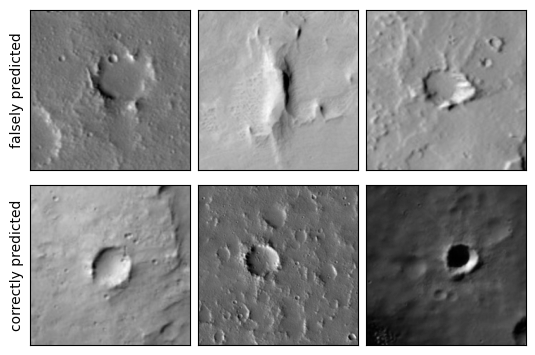

In [ ]:
fig, axes = plt.subplots(2, 3, sharey=True)

selected_images_false = [34, 21, 13]
selected_images_correct = [34, 15, 70]

for i in range(2):
    for j in range(3):
        ax = axes[i][j]
        ax.set_yticks([])
        ax.set_xticks([])

        if i == 0:
            index = false_images[selected_images_false[j]]
        else:
            index = correct_images[selected_images_correct[j]]
            
        ax.imshow(X_test[index], cmap="gray")

axes[0][0].set_ylabel("falsely predicted")
axes[1][0].set_ylabel("correctly predicted")
plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=-0.1)

plt.show()

### 3.2.2 Trainingsset: ADASYN (batch_size=32, learning_rate=0.005)

Epoch 1/30
1289/1289 [==============================] - 1033s 800ms/step - loss: 1.9788 - accuracy: 0.2056 - val_loss: 1.6807 - val_accuracy: 0.1911
Epoch 2/30
1289/1289 [==============================] - 1039s 806ms/step - loss: 1.4315 - accuracy: 0.4566 - val_loss: 1.4270 - val_accuracy: 0.3521
Epoch 3/30
1289/1289 [==============================] - 1047s 812ms/step - loss: 1.0116 - accuracy: 0.6397 - val_loss: 1.4220 - val_accuracy: 0.4592
Epoch 4/30
1289/1289 [==============================] - 1052s 816ms/step - loss: 0.6542 - accuracy: 0.7721 - val_loss: 1.0689 - val_accuracy: 0.5801
Epoch 5/30
1289/1289 [==============================] - 1058s 820ms/step - loss: 0.4415 - accuracy: 0.8431 - val_loss: 1.1421 - val_accuracy: 0.5840
Epoch 6/30
1289/1289 [==============================] - 1063s 824ms/step - loss: 0.3299 - accuracy: 0.8831 - val_loss: 0.8250 - val_accuracy: 0.6826
Epoch 7/30
1289/1289 [==============================] - 1062s 824ms/step - loss: 0.2592 - accuracy: 0.9078

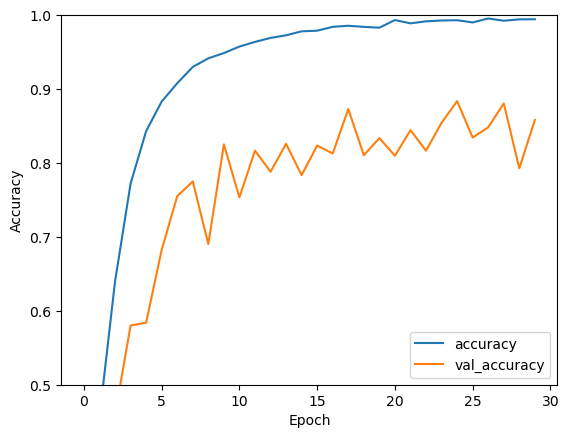

95/95 - 13s - loss: 0.6384 - accuracy: 0.8547 - 13s/epoch - 138ms/step
Accuracy on the training set: 0.8546895384788513
95/95 [==============================] - 14s 137ms/step
               precision    recall  f1-score   support

        other       0.85      0.98      0.91      2180
       crater       0.88      0.59      0.71       316
    dark dune       0.82      0.46      0.59        78
 slope streak       0.85      0.25      0.38       203
  bright dune       0.97      0.78      0.86        86
impact ejecta       0.58      0.46      0.51        24
 swiss cheese       0.92      0.88      0.90        78
       spider       0.84      0.57      0.68        63

     accuracy                           0.85      3028
    macro avg       0.84      0.62      0.69      3028
 weighted avg       0.86      0.85      0.84      3028



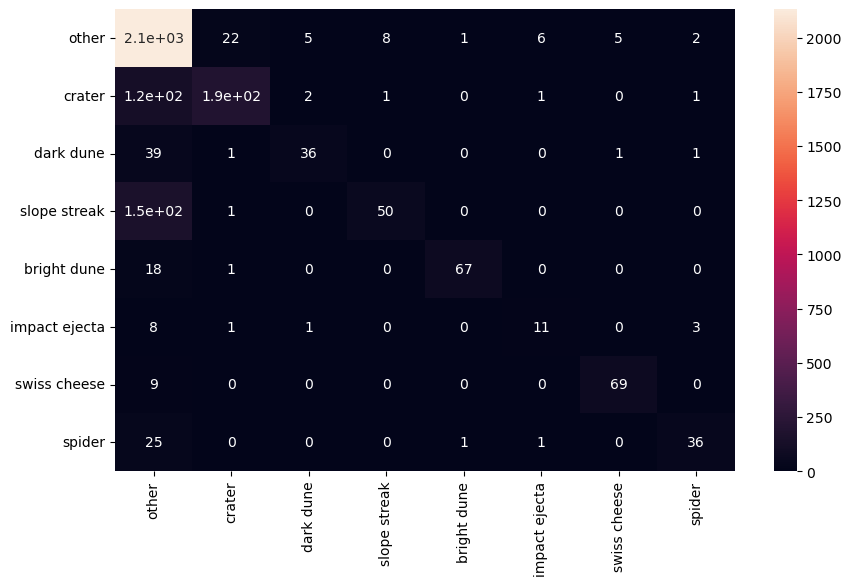

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_t_A_A_S, y_t_A_A_S, = shuffle_data(X_t_A_A, y_t_A_A) # ADASYN data

# Hyperparameters
learning_rate = 0.005
momentum = 0.9
batch_size = 32
epochs = 30

google_A, history_google_A = run_google(X_train=X_t_A_A_S, y_train=y_t_A_A_S, 
                                        X_val=X_val, y_val=y_val,
                                        X_test=X_test, y_test=y_test,
                                        learning_rate=learning_rate, momentum=momentum,
                                        batch_size=batch_size, epochs=epochs,
                                        class_names=class_names)

### 3.2.3 Trainingsset: Original (batch_size=32, learning_rate=0.005)

Epoch 1/30
436/436 [==============================] - 400s 912ms/step - loss: 1.7878 - accuracy: 0.3489 - val_loss: 1.3588 - val_accuracy: 0.8143
Epoch 2/30
436/436 [==============================] - 395s 907ms/step - loss: 1.7919 - accuracy: 0.3484 - val_loss: 1.9281 - val_accuracy: 0.0778
Epoch 3/30
436/436 [==============================] - 391s 898ms/step - loss: 1.7164 - accuracy: 0.3606 - val_loss: 1.7724 - val_accuracy: 0.0863
Epoch 4/30
436/436 [==============================] - 394s 905ms/step - loss: 1.4712 - accuracy: 0.4434 - val_loss: 1.9097 - val_accuracy: 0.2897
Epoch 5/30
436/436 [==============================] - 395s 907ms/step - loss: 1.3157 - accuracy: 0.5063 - val_loss: 1.0760 - val_accuracy: 0.5763
Epoch 6/30
436/436 [==============================] - 397s 911ms/step - loss: 1.2051 - accuracy: 0.5525 - val_loss: 1.0143 - val_accuracy: 0.8228
Epoch 7/30
436/436 [==============================] - 398s 912ms/step - loss: 1.1015 - accuracy: 0.5867 - val_loss: 1.1280 -

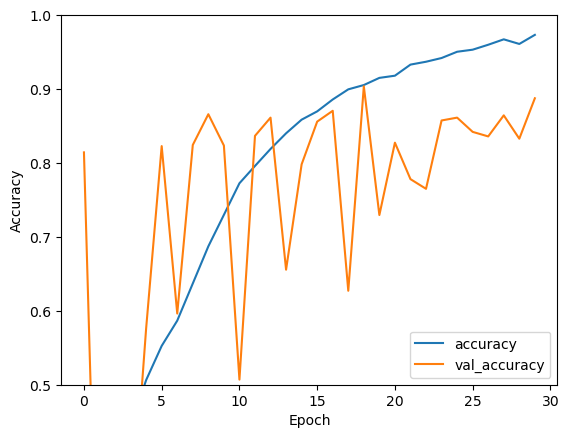

95/95 - 14s - loss: 0.5101 - accuracy: 0.8923 - 14s/epoch - 150ms/step
Accuracy on the training set: 0.8923381567001343
95/95 [==============================] - 15s 151ms/step
               precision    recall  f1-score   support

        other       0.90      0.98      0.94      2302
       crater       0.91      0.63      0.74       307
    dark dune       0.91      0.34      0.50       116
 slope streak       0.69      0.53      0.60        78
  bright dune       1.00      0.79      0.88        87
impact ejecta       0.16      0.38      0.22         8
 swiss cheese       0.95      0.85      0.89        84
       spider       0.81      0.76      0.79        46

     accuracy                           0.89      3028
    macro avg       0.79      0.66      0.70      3028
 weighted avg       0.89      0.89      0.88      3028



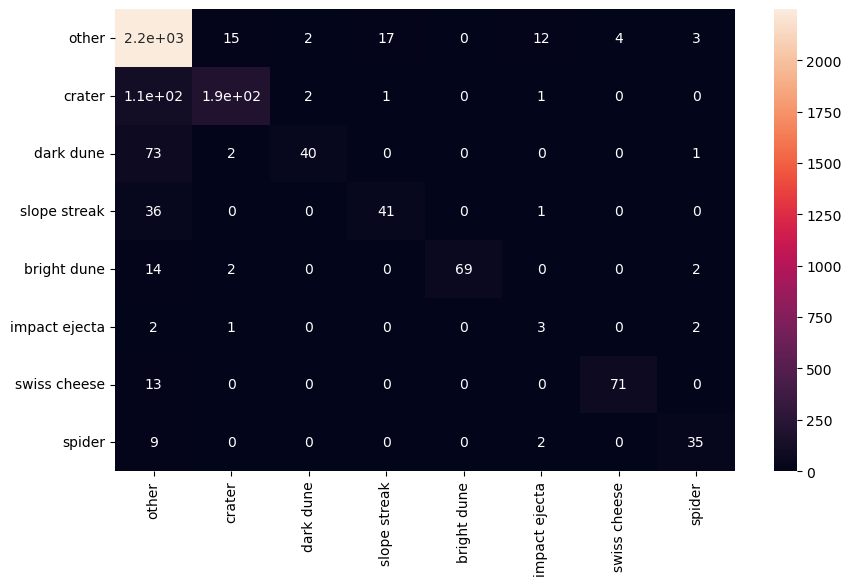

In [ ]:
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

X_train_A_S, y_train_A_S, = shuffle_data(X_train_A, y_train_A) # Original data

# Hyperparameters
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9
batch_size = 32
epochs = 30

google_O, history_google_O = run_google(X_train=X_train_A_S, y_train=y_train_A_S, 
                                        X_val=X_val, y_val=y_val,
                                        X_test=X_test, y_test=y_test,
                                        learning_rate=learning_rate, momentum=momentum,
                                        batch_size=batch_size, epochs=epochs,
                                        class_names=class_names)